In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [11]:
# Set TensorFlow logging level to suppress unnecessary logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Colors and labels for each class
class_colors = {
    0: (255, 0, 0),  # Red for 'car'
    1: (0, 255, 0),  # Green for 'bus'
    2: (0, 0, 255),  # Blue for 'motorcycle'
    3: (255, 255, 0),  # Yellow for 'ambulance'
    4: (0, 255, 255)  # Cyan for 'truck'
}

class_labels = {
    0: 'car',
    1: 'bus',
    2: 'motorcycle',
    3: 'ambulance',
    4: 'truck'
}

In [13]:
# Helper function to parse TFRecord
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    parsed_example = tf.io.parse_single_example(example, feature_description)
    
    # Decode and preprocess the image
    image = tf.io.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, [416, 416])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    # Extract bounding box coordinates and labels
    xmin = parsed_example['image/object/bbox/xmin'].values[0]
    xmax = parsed_example['image/object/bbox/xmax'].values[0]
    ymin = parsed_example['image/object/bbox/ymin'].values[0]
    ymax = parsed_example['image/object/bbox/ymax'].values[0]
    label = parsed_example['image/object/class/label'].values[0]
    
    # One-hot encode the label (5 classes)
    one_hot_label = tf.one_hot(label, depth=5)
    
    # Bounding box + one-hot encoded class label
    bbox = tf.stack([ymin, xmin, ymax, xmax], axis=-1)
    return image, tf.concat([bbox, one_hot_label], axis=0)

# Function to load dataset from TFRecord files
def load_dataset(tfrecord_file, batch_size, shuffle=False):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    parsed_dataset = raw_dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        parsed_dataset = parsed_dataset.shuffle(buffer_size=1000)
    
    parsed_dataset = parsed_dataset.batch(batch_size)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    
    return parsed_dataset

# CNN model for object detection
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(416, 416, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(9, activation='sigmoid')  # Output: 4 coords + 5 class probabilities
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Function to draw bounding boxes with class labels and confidence
def draw_bounding_boxes(image, pred_bbox_class):
    image = (image.numpy() * 255).astype(np.uint8)  # Convert back to uint8
    
    ymin, xmin, ymax, xmax = pred_bbox_class[:4]
    class_probs = pred_bbox_class[4:]
    
    # Get the class with the highest probability
    class_idx = np.argmax(class_probs)
    confidence = class_probs[class_idx]
    
    if confidence >= 0.4:  # Only draw if confidence > 0.4
        color = class_colors[class_idx]
        label = class_labels[class_idx]
        
        # Denormalize bbox
        height, width = image.shape[:2]
        xmin, xmax = int(xmin * width), int(xmax * width)
        ymin, ymax = int(ymin * height), int(ymax * height)
        
        # Draw the bounding box and label
        image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)
        label_with_conf = f'{label}: {confidence:.2f}'
        cv2.putText(image, label_with_conf, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    return image

# Function to test the model and visualize predictions
def test_and_visualize(model, test_dataset):
    for images, _ in test_dataset.take(5):  # Take first 5 samples for visualization
        preds = model.predict(images)
        
        for i in range(len(images)):
            image = images[i]
            pred_bbox_class = preds[i]  # First 4 for bbox, next 5 for class probabilities
            image_with_bbox = draw_bounding_boxes(image, pred_bbox_class)
            
            plt.figure(figsize=(6,6))
            plt.imshow(image_with_bbox)
            plt.axis('off')
            plt.show()

# Training function
def train_model(model, train_dataset, val_dataset, epochs=10):
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs
    )
    return history

# Function to denormalize bounding boxes
def denormalize_bbox(bbox, img_size=(416, 416)):
    height, width = img_size
    ymin, xmin, ymax, xmax = bbox
    return int(xmin * width), int(ymin * height), int(xmax * width), int(ymax * height)

In [14]:
if __name__ == '__main__':
    # Paths to TFRecord files (use raw strings to handle backslashes)
    train_tfrecord = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\train\vehicles.tfrecord'
    val_tfrecord = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\valid\vehicles.tfrecord'
    test_tfrecord = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\test\vehicles.tfrecord'

    # Load datasets
    batch_size = 8
    train_dataset = load_dataset(train_tfrecord, batch_size, shuffle=True)
    val_dataset = load_dataset(val_tfrecord, batch_size)
    test_dataset = load_dataset(test_tfrecord, batch_size=1)

    # Build model
    model = build_model()


In [15]:
history = train_model(model, train_dataset, val_dataset, epochs=10)

Epoch 1/10
110/110 [==============================] - 79s 711ms/step - loss: 0.0937 - mae: 0.2088 - val_loss: 0.0939 - val_mae: 0.2223
Epoch 2/10
110/110 [==============================] - 87s 786ms/step - loss: 0.0320 - mae: 0.1060 - val_loss: 0.1110 - val_mae: 0.2070
Epoch 3/10
110/110 [==============================] - 90s 815ms/step - loss: 0.0100 - mae: 0.0570 - val_loss: 0.1041 - val_mae: 0.2018
Epoch 4/10
110/110 [==============================] - 89s 804ms/step - loss: 0.0049 - mae: 0.0404 - val_loss: 0.1048 - val_mae: 0.1935
Epoch 5/10
110/110 [==============================] - 89s 805ms/step - loss: 0.0032 - mae: 0.0317 - val_loss: 0.1041 - val_mae: 0.1889
Epoch 6/10
110/110 [==============================] - 88s 799ms/step - loss: 0.0024 - mae: 0.0270 - val_loss: 0.1043 - val_mae: 0.1879
Epoch 7/10
110/110 [==============================] - 86s 779ms/step - loss: 0.0020 - mae: 0.0249 - val_loss: 0.1062 - val_mae: 0.1901
Epoch 8/10
110/110 [==============================] - 8

In [16]:
model.save('D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord')

INFO:tensorflow:Assets written to: D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\assets


INFO:tensorflow:Assets written to: D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\assets


1/1 [==============================] - 0s 84ms/step


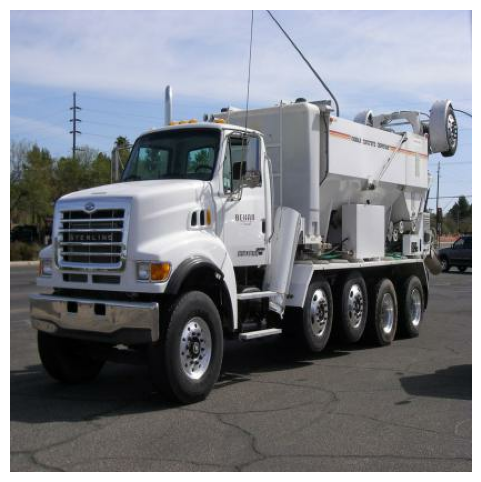

1/1 [==============================] - 0s 45ms/step


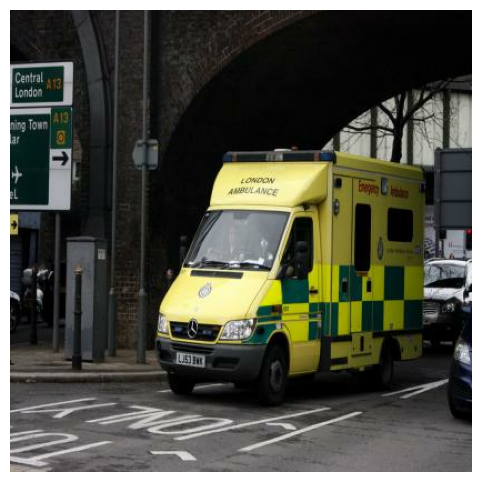

1/1 [==============================] - 0s 69ms/step


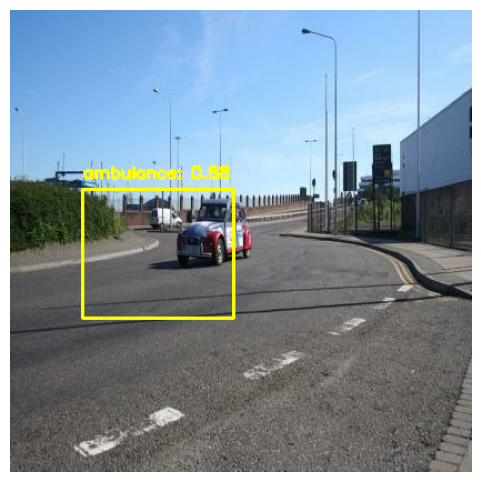

1/1 [==============================] - 0s 34ms/step


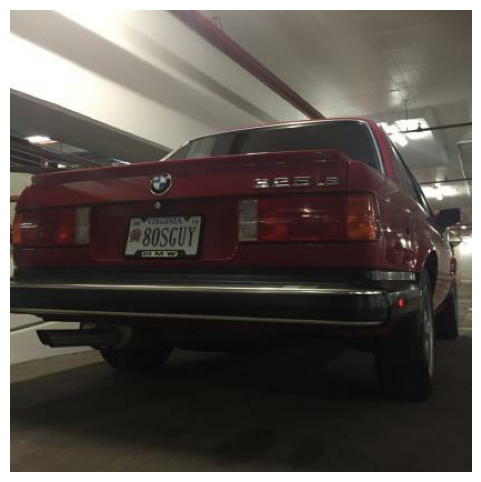

1/1 [==============================] - 0s 44ms/step


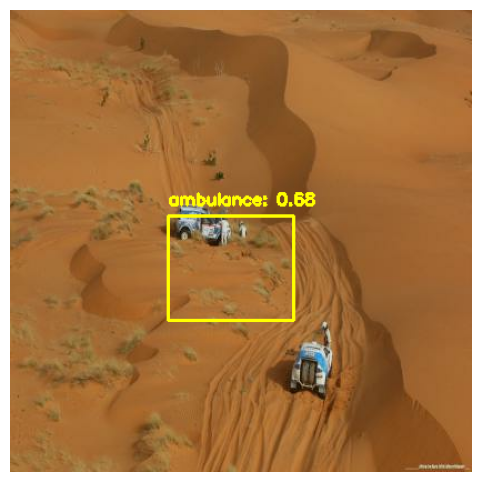

In [17]:
# Test and visualize results
test_and_visualize(model, test_dataset)

In [23]:
# Load the saved model
loaded_model = tf.keras.models.load_model(r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord')

In [24]:
# Preprocess a custom image
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    # Resize the image to the required input size (416, 416)
    image_resized = cv2.resize(image, (416, 416))
    # Normalize the image to range [0, 1]
    image_normalized = image_resized / 255.0
    # Add batch dimension (as the model expects a batch)
    image_input = np.expand_dims(image_normalized, axis=0)
    
    return image_input, image_resized

# Function to predict and draw bounding box on the image
def predict_and_draw_bbox(model, image_input, original_image):
    # Get bounding box prediction from the model
    pred_bbox = model.predict(image_input)[0]  # Get the first result since we use batch size of 1
    
    # Denormalize the bounding box coordinates
    height, width = original_image.shape[:2]
    ymin, xmin, ymax, xmax = pred_bbox
    xmin = int(xmin * width)
    xmax = int(xmax * width)
    ymin = int(ymin * height)
    ymax = int(ymax * height)
    
    # Draw the bounding box on the image
    image_with_bbox = cv2.rectangle(original_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
    # Display the image with bounding box
    plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [25]:
# Example usage
image_path = r'D:\Onedrive\experiments\experiments\Objectron\CNN\Vehicles\Vehicles-OpenImages.v1-416x416.tfrecord\random_test_image_1.jpg'
image_input, original_image = preprocess_image(image_path)
predict_and_draw_bbox(loaded_model, image_input, original_image)

1/1 [==============================] - 0s 70ms/step


ValueError: too many values to unpack (expected 4)